In [1]:
import numpy as np
import cv2
import os

In [2]:
# Make folders for train and test data
if not os.path.exists("data"):
    os.makedirs("data")
    os.makedirs("data/train")
    os.makedirs("data/test")
    os.makedirs("data/train/0")
    os.makedirs("data/train/4")        
    os.makedirs("data/train/5") 
    os.makedirs("data/test/0")
    os.makedirs("data/test/4")        
    os.makedirs("data/test/5") 

In [3]:
# Fill data into the train and test folder


camera = cv2.VideoCapture(0)

while True:
    ret, frame = camera.read()
    
    # Flip the camera
    frame = cv2.flip(frame, 1)
    # Shows no of images in train folder
    zero_train = len(os.listdir('data/train/0'))
    four_train = len(os.listdir('data/train/4'))
    five_train = len(os.listdir('data/train/5'))
    
    # Show no of images in test folder
    zero_test = len(os.listdir('data/test/0'))
    four_test = len(os.listdir('data/test/4'))
    five_test = len(os.listdir('data/test/5'))
    
    # Area of hand detection detections
    x1 = int(0.5*frame.shape[1])
    y1 = 10
    x2 = frame.shape[1] - 10
    y2 = int(0.5*frame.shape[1])
    
    
    cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 1)
    area = frame[y1:y2, x1:x2]
    area = cv2.resize(area, (64, 64))
    
    area = cv2.cvtColor(area, cv2.COLOR_BGR2GRAY)
    ret2, area = cv2.threshold(area, 120, 255, cv2.THRESH_BINARY)
    cv2.imshow("area", area) 
    
    
    cv2.putText(frame,'Images on 0 : ' + str(zero_train),(200,25), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),1)
    cv2.putText(frame,'Images on 4 : ' + str(four_train),(200,50), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),1)
    cv2.putText(frame,'Images on 5 : ' + str(five_train),(200,75), cv2.FONT_HERSHEY_SIMPLEX, 1,(255,255,255),1)
    cv2.imshow("frame", frame)

          
     
    
    if cv2.waitKey(10) & 0xFF == ord("q"):
        break
    if cv2.waitKey(10) & 0xFF == ord("0"):
        cv2.imwrite("data/train/0/" + str(zero_train) + ".jpg" , area)
    if cv2.waitKey(10) & 0xFF == ord("4"):
        cv2.imwrite("data/train/4/" + str(four_train) + ".jpg" , area)
    if cv2.waitKey(10) & 0xFF == ord("5"):
        cv2.imwrite("data/train/5/" + str(five_train) + ".jpg" , area)
        
camera.release()
cv2.destroyAllWindows()

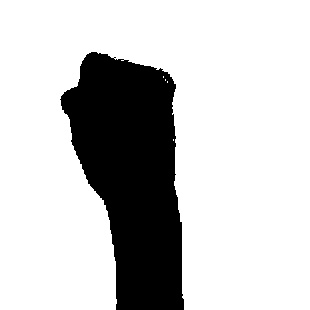

data/train/0/5.jpg


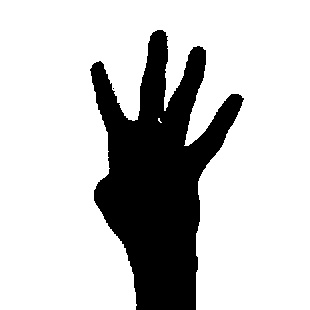

data/train/4/5.jpg


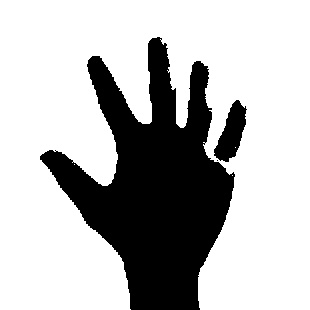

data/train/5/5.jpg


In [4]:
from IPython.display import Image, display
from glob import glob
listofImageNames = glob('data/train/5/5.jpg', recursive=True)
for i in [0, 4, 5]:
    for imageName in glob('data/train/'+ str(i)+'/5.jpg', recursive=True):
        display(Image(filename=imageName))
        print(imageName),

In [5]:
# Trainig of data using CNN

In [6]:
from keras.models import Sequential
from keras.layers import Convolution2D
from keras.layers import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dense

Using TensorFlow backend.


In [7]:
classifier = Sequential()

In [8]:
classifier.add(Convolution2D(64, (3, 3), input_shape = (64, 64, 1), activation = "relu"))
classifier.add(MaxPooling2D(pool_size = (2, 2)))
classifier.add(Convolution2D(32, (3, 3), activation='relu'))
classifier.add(MaxPooling2D(pool_size=(2, 2)))
classifier.add(Flatten())


#Fully connected layers
classifier.add(Dense(units = 256, activation = "relu"))
classifier.add(Dense(units = 6, activation = "sigmoid"))


# Compiling the model
classifier.compile(optimizer="adam", loss = "categorical_crossentropy", metrics=["accuracy"])

In [9]:
# Data Augmentation to avoid overfitting
from keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1./255, shear_range=0.1, zoom_range = 0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)
training_set = train_datagen.flow_from_directory("data/train", target_size=(64, 64), batch_size=4, 
                                                 color_mode="grayscale", class_mode= "categorical")
test_set = test_datagen.flow_from_directory("data/test", target_size=(64, 64), batch_size=4, 
                                                 color_mode="grayscale", class_mode= "categorical")


# Fitting the training_set and test_set to the classifier
classifier.fit_generator(training_set, steps_per_epoch=600, epochs = 2, validation_data=test_set,
                         validation_steps=30)

Found 600 images belonging to 6 classes.
Found 30 images belonging to 6 classes.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where

Epoch 1/2
600/600 [==============================] - 32s 54ms/step - loss: 0.7756 - accuracy: 0.6908 - val_loss: 0.4845 - val_accuracy: 0.9298
Epoch 2/2
600/600 [==============================] - 33s 55ms/step - loss: 0.2201 - accuracy: 0.9092 - val_loss: 0.0094 - val_accuracy: 0.9375


In [10]:
# Serializing model to JSON
model_json = classifier.to_json()
with open ("model.json", "w") as json_file:
    json_file.write(model_json)
    
# Serializing weights to HDF5
classifier.save_weights("model.h5")

In [11]:
# Loading model from json
from keras.models import model_from_json
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)

# Loading weights
loaded_model.load_weights("model.h5")


In [12]:
# Prediction using web cam

In [13]:
import vlc
import operator
player = vlc.MediaPlayer("/home/rishabh/Music/zimmer.mp4")
import os, sys

cap = cv2.VideoCapture(0)

while True:
    _, frame = cap.read()
    
    x1 = int(0.5*frame.shape[1])
    y1 = 10
    x2 = frame.shape[1] - 10
    y2 = int(0.5*frame.shape[1])
    
    
    cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 1)
    area = frame[y1:y2, x1:x2]
    area = cv2.resize(area, (64, 64))
    
    area = cv2.cvtColor(area, cv2.COLOR_BGR2GRAY)
    ret2, area = cv2.threshold(area, 120, 255, cv2.THRESH_BINARY)
    cv2.imshow("area", area)
#     cv2.imshow("screen_test", frame)
    
    result = loaded_model.predict(area.reshape(1, 64, 64, 1))
    if result[0][0] == 1:
        player.play()
    elif result[0][5] == 1:
        for i in range (100):
            player.audio_set_volume(100-i)
            break
    elif result[0][3] == 1:
        for i in range (100):
            player.audio_set_volume(i)
            break
    prediction = {'Play Video': result[0][0], 
                  'Try Again': result[0][1], 
                  'Try Again': result[0][2],
                  'Try Again': result[0][3],
                  'Mute': result[0][4],
                  'Sound': result[0][5]}
    prediction = sorted(prediction.items(), key=operator.itemgetter(1), reverse=True)
    

    cv2.putText(frame, prediction[0][0], (10, 120), cv2.FONT_HERSHEY_PLAIN, 1, (0,255,255), 1)    
    cv2.imshow("Frame", frame)
    
    if cv2.waitKey(1) & 0xFF == ord("q"):
        break
cap.release()
cv2.destroyAllWindows()